# Initializations

In [27]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from IPython import parallel

rc = parallel.Client()
all_engines = rc[:]
lbv = rc.load_balanced_view()

print len(all_engines)

48


In [51]:
%%px --local

import sys
sys.path.append("/home/nbserver/urbanization-patterns/cityanalysis")
from cityanalysis import City
from cityanalysis import fractal_dimension


In [228]:
%%px --local 

from skimage.transform import resize
from skimage.io import imread, imsave

def read_img(f, imgSize=None):
    img = imread(f)
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    img = (img - img.min()) / float((img.max() - img.min()))
    return img

# Show stats on one example

In [229]:
myfile_SAR = '/home/data/world-cities/urban_areas_over_10kpop_log/SAR_fr_paris,-fr-(pop-2.1M)_very-large_2110694_48.8667_2.3333.png'
myfile_POP = '/home/data/world-cities/urban_areas_over_10kpop_log/POP_fr_paris,-fr-(pop-2.1M)_very-large_2110694_48.8667_2.3333.png'
myfile_NLI = '/home/data/world-cities/urban_areas_over_10kpop_log/NLI_fr_paris,-fr-(pop-2.1M)_very-large_2110694_48.8667_2.3333.png'

img = []
for f in [myfile_SAR, myfile_POP, myfile_NLI]:
    img.append(read_img(f))
    
img = np.concatenate([a[...,np.newaxis] for a in img], axis=2)

paris = City(img, name='Paris', sources=["built", "pop", "lum"])

#### Fraction of occupied area

In [191]:
paris.compute_average()
paris.avg_areas

array([ 0.08850469,  0.58702478,  0.27678161])

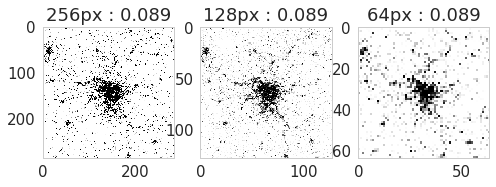

In [89]:
# using skimage

img_64 = resize(img[:,:,0], (64,64), preserve_range=True)
img_128= resize(img[:,:,0], (128,128), preserve_range=True)

fig, ax = plt.subplots(1,3, figsize=(8,4))
ax[0].imshow(img[:,:,0]); ax[0].set_title("256px : %2.3f"%paris.compute_average(0))
ax[1].imshow(img_128); ax[1].set_title("128px : %2.3f"%paris.compute_average(0))
ax[2].imshow(img_64); ax[2].set_title("64px : %2.3f"%paris.compute_average(0))

#### Distribution of patch areas

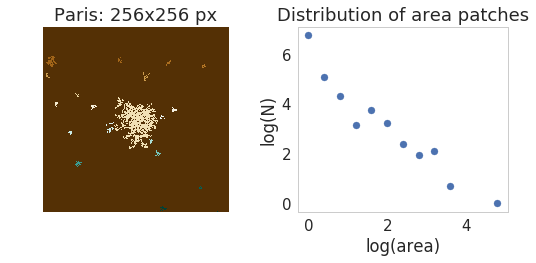

In [93]:
sns.set_context("notebook", font_scale=1.5)

paris.compute_regions(0)

# plot just top 20 areas
mask1 = paris.masks_regions[0].copy()
for a in areas[20:]:
    mask1[mask1==a[0]] = 0

fig, ax = plt.subplots(1,2, figsize=(8,4))
imgplot = ax[0].imshow(mask1)
imgplot.set_cmap('BrBG')
ax[0].set_title("Paris: 256x256 px")
ax[0].axis("off")

# plot distribution of area sizes
ax[1].scatter(np.log(paris.areas_distr[0][1][:-1]), paris.areas_distr[0][0], marker="o")
ax[1].set_title("Distribution of area patches")
ax[1].set_ylabel("log(N)")
ax[1].set_xlabel("log(area)")

plt.tight_layout()

#### Fractal dimension

('Minkowski-Bouligand dimension (computed): ', 1.5993838379948804)
('Haussdorf dimension (theoretical):        ', 1.5849625007211563)


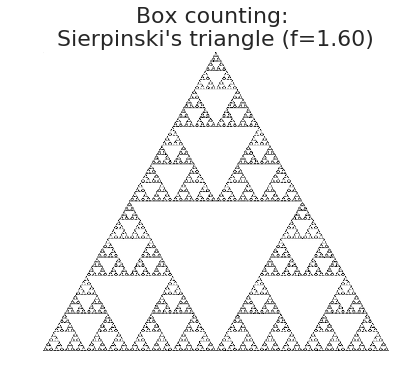

In [63]:
I = read_img("sierpinski.png")
plt.imshow(1-I)
plt.axis("off")
plt.title("Box counting: \nSierpinski's triangle (f=%2.2f)"%fractal_dimension(I)[0], 
          fontsize=22)

print("Minkowski-Bouligand dimension (computed): ", fractal_dimension(I)[0])
print("Haussdorf dimension (theoretical):        ", (np.log(3)/np.log(2)))

In [112]:
frac_dim = paris.compute_fractal_dim(0)
print paris.fractal_dim

_, log_box_sizes, log_box_counts = fractal_dimension(paris.M[:,:,0])

[ 1.6221733   0.92452003         nan]


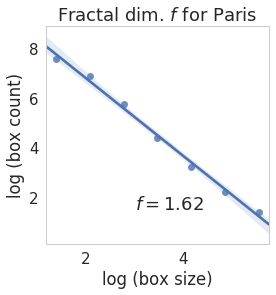

In [65]:
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(4,4))
ax = sns.regplot(log_box_sizes, log_box_counts, lowess=False)
plt.xlabel("log (box size)")
plt.ylabel("log (box count)")
plt.title("Fractal dim. $f$ for Paris")

ax.annotate('$f=$%.2f'%frac_dim, xy=(2, 1), xytext=(3, 1.5))


(-0.5, 285.5, 285.5, -0.5)

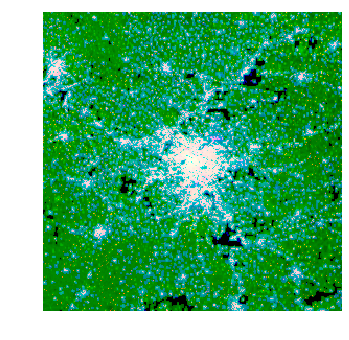

In [56]:
plt.imshow(img)
plt.axis("off")

#### Compute distance profiles

In [128]:
profiles = paris.compute_profile()

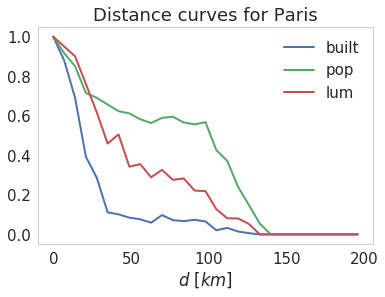

In [137]:
xlabels = np.arange(29) * 10 * 200 / 286.0

plt.figure(figsize=(6,4))
for c,p in profiles.iteritems():
    plt.plot(xlabels, p[0], label=paris.channels[c], lw=2)
plt.legend(loc="best")
plt.title("Distance curves for Paris")
plt.xlabel("$d \ [km]$")

In [138]:
paris.analyze()

#### Another example - a coastal city with lots of water around (where nothing can be built)
We would like to compute a mask where no builtup can occur. 
Right now, we chose the regions with 0 population as first pass. This is because the LandScan product has been thoroughly processed to account for water bodies and other places that obviously cannot be populated. We may have to change this in the future. 

In [234]:
myfile_SAR = '/home/data/world-cities/urban_areas_over_10kpop_log/SAR_us_boston,-us-(pop-571.3k)_medium_571281_42.3583_-71.0603.png'
myfile_POP = '/home/data/world-cities/urban_areas_over_10kpop_log/POP_us_boston,-us-(pop-571.3k)_medium_571281_42.3583_-71.0603.png'
myfile_NLI = '/home/data/world-cities/urban_areas_over_10kpop_log/NLI_us_boston,-us-(pop-571.3k)_medium_571281_42.3583_-71.0603.png'

img = []
for f in [myfile_SAR, myfile_POP, myfile_NLI]:
    img.append(read_img(f))
    
img = np.concatenate([a[...,np.newaxis] for a in img], axis=2)

mask = (imread(myfile_POP) > 0).astype(np.uint8)

boston = City(img, name='Boston', mask=mask, sources=["built", "pop", "lum"])

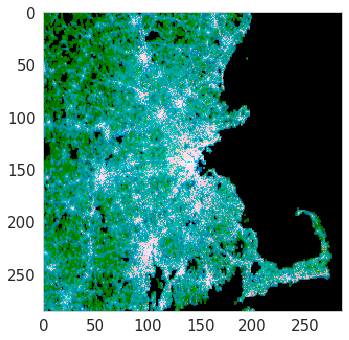

In [235]:
plt.imshow(boston.M)

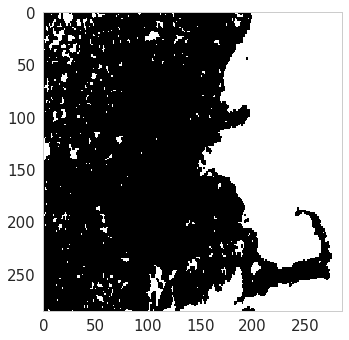

In [240]:
plt.imshow(mask)

# Compute spatial stats across all cities

#### Gather all data sources

In [241]:
dataroot = "/home/data/world-cities/"

In [140]:
regions_df = pd.read_csv("/home/data/countries_regions.csv")

country2region = {r:c for r,c in zip(regions_df['alpha-2'].str.lower(), regions_df['region'])}


In [142]:
import glob

files = glob.glob(dataroot + "urban_areas_over_10kpop_log/*.png")
files_df = []
for f in files:
    s = f.split("/")
    fname = s[-1]
    cls = fname.split("_")[3]
    _,country,city,_,pop,lat,lon = fname.split("_")
    files_df.append((f, cls, country, pop))
    
files_df = pd.DataFrame(files_df, \
                columns=["filename", "class", "country", "population"])
files_df['city'] = files_df['filename'].apply(lambda s: os.path.basename(s).split("_")[2].replace("-"," "))
files_df['region'] = files_df['country'].apply(lambda x: country2region[x] if x in country2region else np.nan)
files_df['source'] = files_df['filename'].apply(lambda s: os.path.basename(s).split("_")[0])

len(files_df)

125120

In [143]:
files_df.head()

,filename,class,country,population,city,region,source
0,/home/data/world-cities/urban_areas_over_10kpo...,very-small,us,44071,"saint louis park, us (pop 44.1k)",Americas,SAR
1,/home/data/world-cities/urban_areas_over_10kpo...,very-small,us,44174,"pittsfield, us (pop 44.2k)",Americas,SAR
2,/home/data/world-cities/urban_areas_over_10kpo...,very-small,br,42721,"caninde, br (pop 42.7k)",Americas,SAR
3,/home/data/world-cities/urban_areas_over_10kpo...,very-small,in,14046,"semaria, in (pop 14.0k)",Asia,NLI
4,/home/data/world-cities/urban_areas_over_10kpo...,very-small,es,22264,"baranain, es (pop 22.3k)",Europe,NLI


In [157]:
sources = files_df.groupby("city").apply(\
                    lambda x: dict(zip(x['source'], x['filename'])))

In [158]:
sources[0]

{'NLI': '/home/data/world-cities/urban_areas_over_10kpop_log/NLI_es_a-coruna,-es-(pop-236.0k)_medium_236010_43.3666_-8.4068.png',
 'PNM': '/home/data/world-cities/urban_areas_over_10kpop_log/PNM_es_a-coruna,-es-(pop-236.0k)_medium_236010_43.3666_-8.4068.png',
 'POP': '/home/data/world-cities/urban_areas_over_10kpop_log/POP_es_a-coruna,-es-(pop-236.0k)_medium_236010_43.3666_-8.4068.png',
 'PSM': '/home/data/world-cities/urban_areas_over_10kpop_log/PSM_es_a-coruna,-es-(pop-236.0k)_medium_236010_43.3666_-8.4068.png',
 'SAR': '/home/data/world-cities/urban_areas_over_10kpop_log/SAR_es_a-coruna,-es-(pop-236.0k)_medium_236010_43.3666_-8.4068.png'}

#### Compute stats in parallel

In [192]:
def compute_stats(filenames):
    img = []
    for f in [filenames['SAR'], filenames['POP'], filenames['NLI']]:
        img.append(read_img(f))
    img = np.concatenate([a[...,np.newaxis] for a in img], axis=2)
    city = City(img, sources=["bldg", "pop", "lum"])
    city.analyze()
    return city.profiles, city.fractal_dim, city.avg_areas

In [194]:
profiles, fractal_dim, avg_areas = compute_stats(sources[0])

In [195]:
profiles

{0: (array([ 0.99997661,  0.28511336,  0.07650948,  0.37012753,  0.24153254,
          0.2582709 ,  0.3788873 ,  0.35809797,  0.3686727 ,  0.41148874,
          0.44269117,  0.46748556,  0.48806069,  0.55154045,  0.57821988,
          0.44148794,  0.40478406,  0.34135648,  0.22315319,  0.14788645,
          0.02935711,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ]),
  array([  6.79238012e-16,   3.33023802e-01,   1.42583214e-01,
           3.71135217e-01,   3.18235627e-01,   3.12423031e-01,
           3.50637059e-01,   3.43213972e-01,   3.38534611e-01,
           3.56100146e-01,   3.64467635e-01,   3.66429476e-01,
           3.81361326e-01,   3.76610653e-01,   3.80514715e-01,
           3.69635558e-01,   3.63759718e-01,   3.48095255e-01,
           3.01177906e-01,   2.55907924e-01,   1.19865407e-01,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+0

In [ ]:
compute_stats(f, imgSize=None, max_log_area=6)

In [ ]:
%%timeit  
compute_stats(f, imgSize=None, max_log_area=9)

In [ ]:
%%timeit 
compute_stats(f, imgSize=128, max_log_area=6.7)

In [ ]:
res_orig = lbv.map_async(lambda f: compute_stats(f, imgSize=None, max_log_area=6), \
                         myfiles_df['filename'].values.tolist())
stats_orig = pd.DataFrame(res_orig.result(), 
                          columns=["filename", "build pct", 
                                   "patch distr", "top patch areas", "fractal dim", "box counts"])

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax2 = ax.twinx()
myfiles_df['build pct 286'].hist(bins=100, ax=ax)
q = myfiles_df['build pct 286'].quantile(np.linspace(0.0,1,100))
ax2.plot(q, q.index, label="cdf", color="black")
sns.set_style("whitegrid", {'axes.grid' : False})
plt.title("Fraction of built land: 25k worldwide cities", fontsize=16)
ax.set_xlabel("% built land", fontsize=14)
ax.set_ylabel("# cities", fontsize=14)
ax2.set_ylabel("% cities", fontsize=14)


#### Save to file